Tensor flow development

In [465]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (12,8)})



In [467]:
# Load data as Pandas dataframe. We concat the data to clean the data in both train and set
train = pd.read_csv('/data/train.csv', )
test = pd.read_csv('/data/test.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [468]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [469]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1046,NaN,NaN,NaN,29.8811,14.4135,0.17,21,28,39,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1307,3,S,914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1308,NaN,NaN,NaN,33.2955,51.7587,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


In [470]:
df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [472]:
# create new Title column in order to ocalculate more appropriately the missing ages
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [473]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [474]:
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Mlle          2
Major         2
Lady          1
Countess      1
Dona          1
Sir           1
Mme           1
Capt          1
Jonkheer      1
Don           1
Name: Title, dtype: int64

In [475]:
# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

In [476]:
# confirm that we are left with just six values
df['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Dr          8
Rev         8
Name: Title, dtype: int64

In [477]:
# impute missing Age values using median of Title groups
title_ages = dict(df.groupby('Title')['Age'].median())

# create a column of the average ages
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

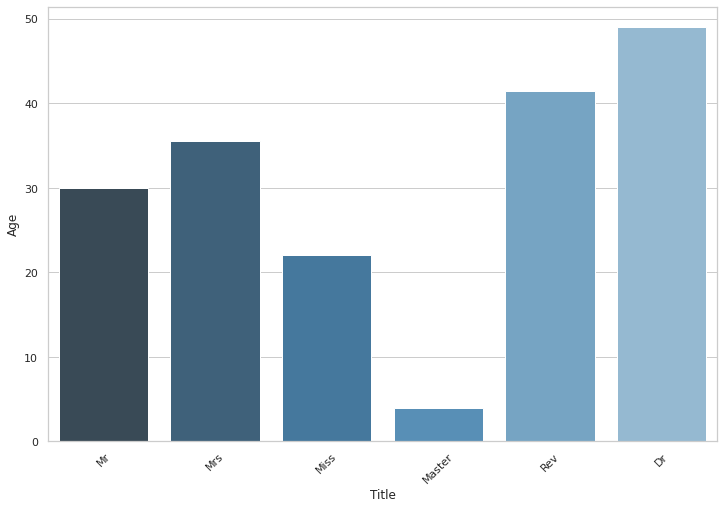

In [478]:
sns.barplot(x='Title', y='Age', data=df, estimator=np.median, ci=None, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

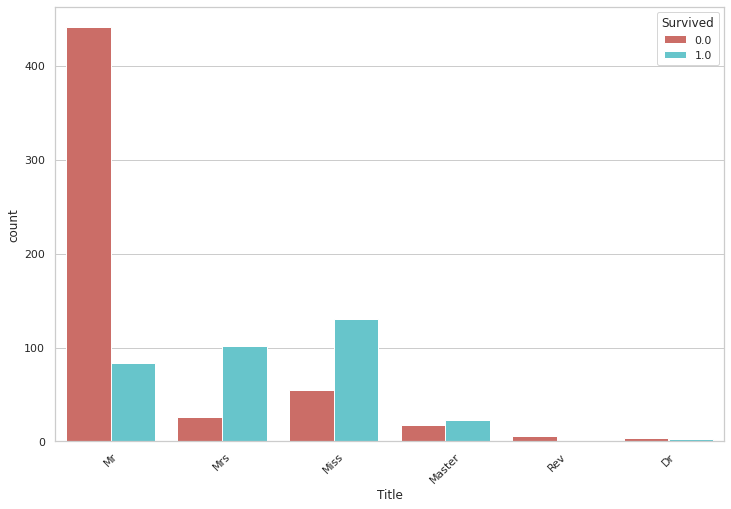

In [479]:
sns.countplot(x='Title', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

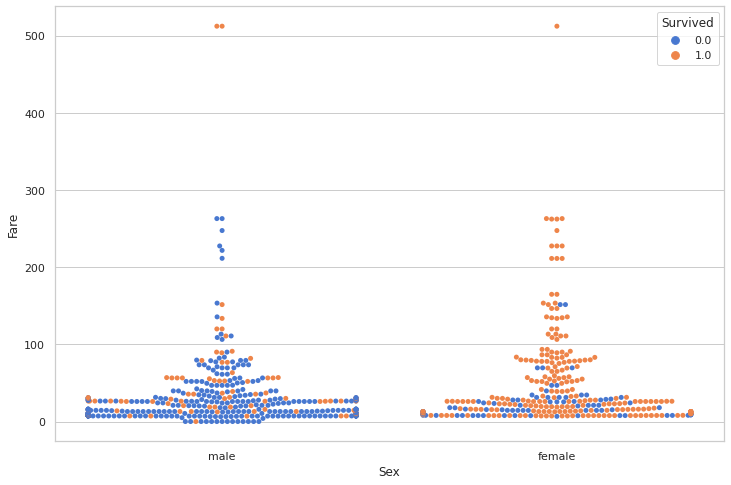

In [480]:
sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=df)
plt.show()

In [481]:
# impute missing Fare values using median of Pclass groups
class_fares = dict(df.groupby('Pclass')['Fare'].median())

# create a column of the average fares
df['fare_med'] = df['Pclass'].apply(lambda x: class_fares[x])

# replace all missing fares with the value in this column
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']
    

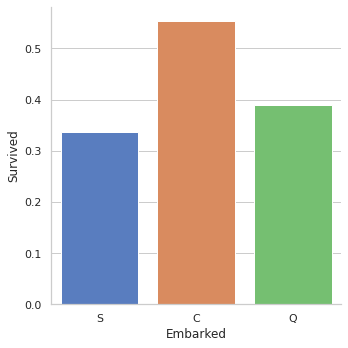

In [482]:
sns.catplot(x='Embarked', y='Survived', data=df,
            kind='bar', palette='muted', ci=None)
plt.show()

In [483]:
# Need to know what is Backfill!!!

df['Embarked'].fillna(method='backfill', inplace=True)

In [484]:
df['Family_Size'] = df['Parch'] + df['SibSp']

In [485]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,NaN,NaN,NaN,29.5624,13.1654,0.17,22,30,35.5,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1309,NaN,NaN,NaN,33.2762,51.7436,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


In [486]:
train = df[pd.notnull(df['Survived'])]
test = df[pd.isnull(df['Survived'])]

In [487]:
train.to_csv('/data/train_clean.csv', index=False)
test.to_csv('/data/test_clean.csv', index=False)